# Прогнозирование заказов такси

Построена модель случайного леса для предсказания временного ряда заказов такси (RMSE = 46 на тестовой выборке)

## Описание данных

* __num_orders__ - число заказов такси

## Оглавление
* [Вспомогательные функции](#1)
* [Первичный анализ данных и предобработка](#2)
* [Подготовка данных к обучению](#3)
* [Модели](#4)
    * [Тривиальная модель](#4.1)
    * [Линейная регрессия](#4.2)
    * [Случайный лес](#4.3)
* [Общий вывод](#5)

In [2]:
%pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings                                  
warnings.filterwarnings('ignore')


<a id = '1'></a>
## Вспомогательные функции

In [4]:
# функция для скользящего среднего
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(18, 8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [5]:
# функция для генерации фич
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [6]:
# функция для кросс-вал. временного рада
def timeseriesCVrmse(data, model, n_blocks):
    
    features = data.drop('num_orders', axis = 1)
    target = data['num_orders']
    
    tscv = TimeSeriesSplit(n_splits = n_blocks)
    
    errors = []
    
    for train_ind, valid_ind in tscv.split(data):
        
        model.fit(features.iloc[train_ind], target.iloc[train_ind])
        predicted_valid = model.predict(features.iloc[valid_ind])
        error = mean_squared_error (target.iloc[valid_ind], predicted_valid) ** 0.5
        errors.append(error)
    
    return np.array(errors).mean()

In [7]:
sns.set_theme()

<a id = '2'></a>
## Первичный анализ данных и предобработка

In [8]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
df.isna().sum()

num_orders    0
dtype: int64

In [10]:
df.index.is_monotonic

True

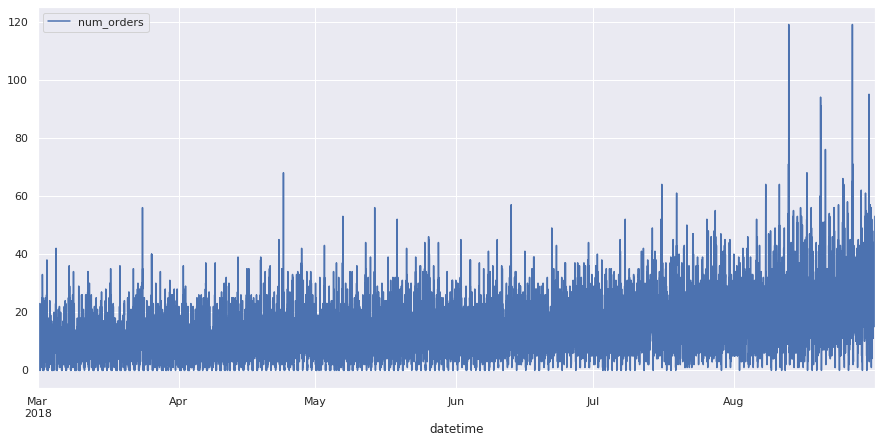

In [11]:
df.plot(figsize=(15, 7))

Рессемплируем ряд, сумма заказов в один час

In [12]:
df = df.resample('1H').sum()

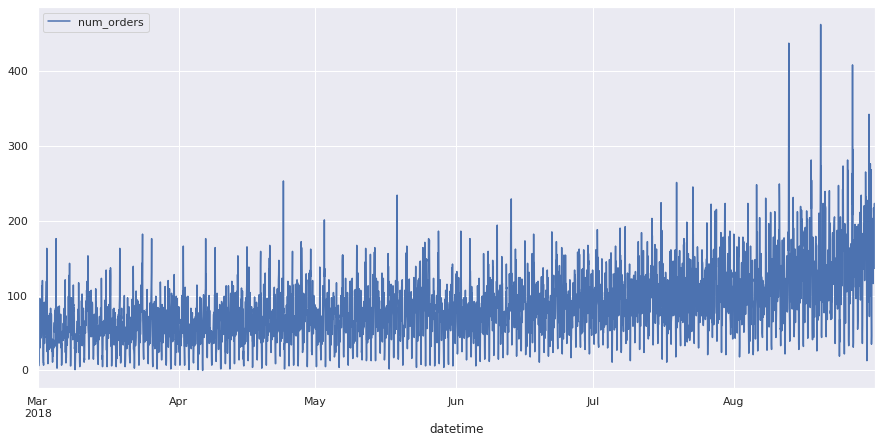

In [13]:
df.plot(figsize=(15, 7))

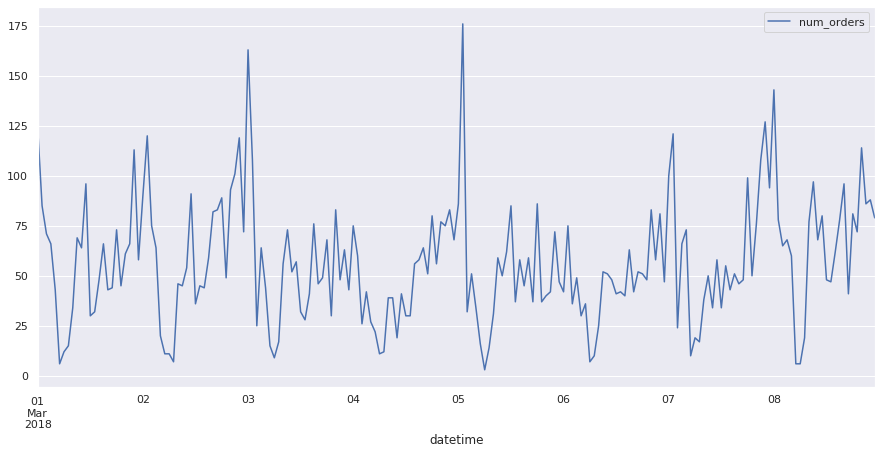

In [14]:
df['2018-03-01':'2018-03-08'].plot(figsize=(15, 7))

Теперь стала просматриваться суточная переодичность ряда, к концу дня заказов становиться больше, после пика наступает резкий спад

__Промежуточный вывод__ 

Даты меняются монотонно, ряд рессемплирован, данные готовы к обучению 

<a id = '3'></a>
## Подготовка данных к обучению
Разобьем ряд на обучающую и тестовую выборки, построим для тестовой выборки доверительные интервалы, выделим аномалии

In [15]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

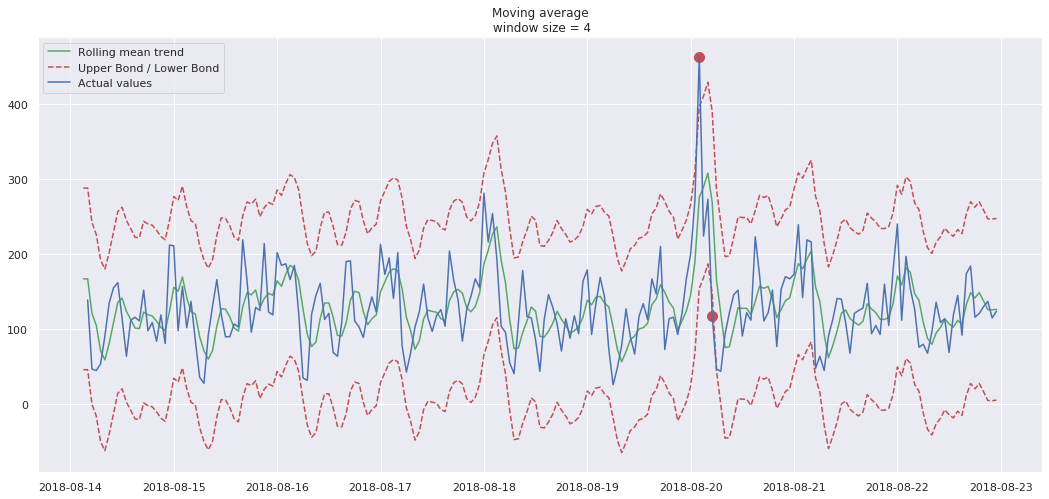

In [16]:
plotMovingAverage(test['2018-08-14':'2018-08-22'], 4, plot_intervals=True, plot_anomalies = True)

Аномальных значений немного, приступаем к построению моделей

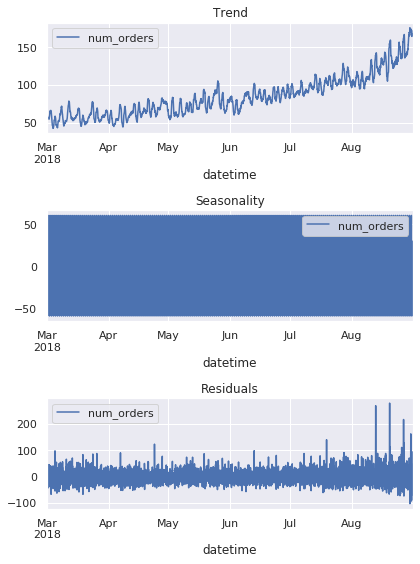

In [17]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На недельном масштабе

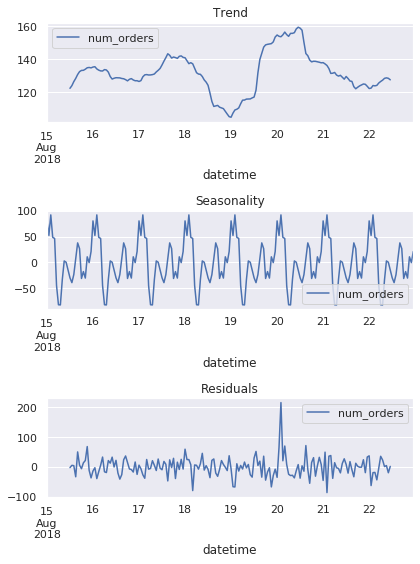

In [18]:
decomposed = seasonal_decompose(df['2018-08-15':'2018-08-22'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

__Промежуточный вывод__
У ряда восходящий тренд, ряд не стационарен. У ряда суточная переодичность, что означает особую значимость лага близкого к 24. В августе увеличивается количество выбросов, что видно из графика остатков. Т.к. RMSE к ним чувствительна, то на тесте можем наблюдать большие значения метрики в сравнении с кросс-валидацией на трейне

<a id = '4'></a>
## Подбор модели

<a id = '4.1'></a>
### Тривиальная модель $\hat{y_t} = y_{t-1}$

В качестве базового прогноза будем считать количество заказов в текущий час равным количеству заказов в предыдущий

In [19]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[len(train) - 1]

print('RMSE:', mean_squared_error(test, pred_previous) ** 0.5)

RMSE: 58.856486242815066


<a id = '4.2'></a>
### Линейная регрессия

Позаимствуем из тренажера функцию для генерации фичей; признаки отличаются не слишком сильно, поэтому масштабировать их не будем

In [20]:
make_features(df, 3, 3)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,93.333333
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,74.000000
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,207.000000
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,186.666667
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,165.666667


Наййдем оптимальное количество фичей для линейной регресии

In [21]:
best_rmse = df['num_orders'].mean()
for max_lag in range(20, 30):
    for rolling_size in range(1, 10):
        
        data =  make_features(df, max_lag, rolling_size)

        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train.dropna(inplace = True)
        
        model = LinearRegression()
        
        rmse = timeseriesCVrmse(train, model, 3)
        
        if rmse < best_rmse:
            
            best_rmse = rmse
            best_lag = max_lag
            best_roll = rolling_size

In [22]:
print('Лучшая RMSE = {:.2f}, при количестве лагов = {} и размере скользящего окна = {}'.format(best_rmse, best_lag, best_roll))

Лучшая RMSE = 27.40, при количестве лагов = 28 и размере скользящего окна = 5


Проверим модель на тестовой выборке

In [23]:
data =  make_features(df, best_lag, best_roll)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train.dropna(inplace = True)
        
model = LinearRegression()

model.fit(train.drop('num_orders', axis = 1),
          train['num_orders']
)        

predicted_test = model.predict(test.drop('num_orders', axis = 1))

rmse = mean_squared_error (test['num_orders'], predicted_test) ** 0.5

print('RMSE линейной регресии на тестовой выборке = {:.2f}'.format(rmse))

RMSE линейной регресии на тестовой выборке = 46.49


Отыграли у тривиальной модели около 10 заказов. Зная оптимальный набор фичей построим более сложную модель

<a id = '4.3'></a>
### Случайный лес

In [24]:
data =  make_features(df, best_lag, best_roll)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

best_model = None
best_rmse = df['num_orders'].mean()
best_est = 0
best_depth = 0
results = {'max_depth': []}
flag = 1
for est in range(10, 31, 5):
    col_name = 'est. number = ' + str(est)
    results[col_name] = []
    for depth in range (2, 21):
        model = RandomForestRegressor (n_estimators=est, max_depth=depth, random_state = 12345)
        rmse = timeseriesCVrmse(train, model, 3)
        if flag == 1:
            results['max_depth'].append(depth)
        results[col_name].append(rmse)
        if best_rmse > rmse:
            best_model = model
            best_rmse = rmse
            best_est = est
            best_depth = depth
    flag = 0
print("RMSE наилучшей модели на кросс-валидации:", best_rmse, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

RMSE наилучшей модели на кросс-валидации: 27.879430677806123 Количество деревьев: 30 Максимальная глубина: 15


Text(0, 0.5, 'RMSE')

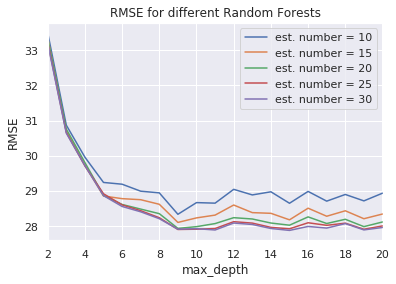

In [25]:
results = pd.DataFrame(results)
results.plot(x = 'max_depth')
plt.title('RMSE for different Random Forests')
plt.ylabel('RMSE')

Проверим модель на тестовой выборке

In [26]:
model = best_model

model.fit(train.drop('num_orders', axis = 1),
          train['num_orders']
)        

predicted_test = model.predict(test.drop('num_orders', axis = 1))

rmse = mean_squared_error (test['num_orders'], predicted_test) ** 0.5

print('RMSE случайного леса на тестовой выборке = {:.2f}'.format(rmse))

RMSE случайного леса на тестовой выборке = 46.08


Результат немного лучше чем у линейной регрессии. Визуализируем предсказания

In [27]:
features_test = test.drop('num_orders', axis = 1)

predicted_test = best_model.predict(features_test)

predictions = pd.DataFrame(test['num_orders'])
predictions['predicted_value'] = predicted_test
predictions

,num_orders,predicted_value
datetime,,
2018-08-13 14:00:00,102,129.989248
2018-08-13 15:00:00,175,140.165948
2018-08-13 16:00:00,144,159.391515
2018-08-13 17:00:00,152,145.795580
2018-08-13 18:00:00,104,107.420513
...,...,...
2018-08-31 19:00:00,136,132.666667
2018-08-31 20:00:00,154,180.400000
2018-08-31 21:00:00,159,171.233333


Text(0, 0.5, 'num. orders')

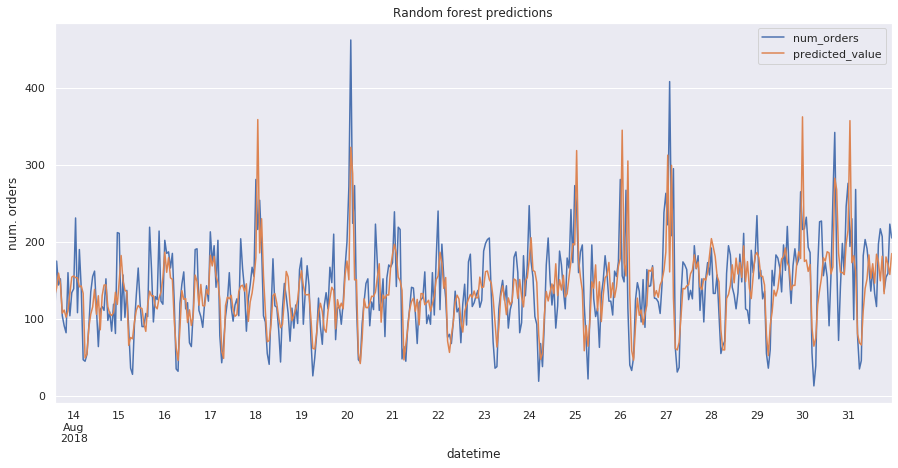

In [28]:
predictions.plot(figsize=(15, 7))
plt.title('Random forest predictions')
plt.ylabel('num. orders')

Аномальные значения модель предсказывает плохо, однако требуемой точности мы добились.

<a id = '5'></a>
## Общий вывод

* У ряда восходящий тренд, ряд не стационарен. У ряда суточная переодичность, что означает особую значимость лага близкого к 24. В августе увеличивается количество выбросов, что видно из графика остатков.


* Перебором нашли оптимальный набор фичей для линейной регресии (макс лаг 28, размер скользящего окна 5), на этом наборе построили случайный лес (30 деревьев с максимальной глубиной 15), удалось добиться требуемой точности на тестовой выборке RMSE = 46 < 48. Большой разрыв между RMSE на кросс-валидации (28) и RMSE на тесте (46) возможно обусловлен возросшим количеством выбросов в августе.